<a href="https://colab.research.google.com/github/mequanent/Bioinformatics-hws/blob/main/hws_110761504.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Clone the repository first using the following command
!npx degit https://github.com/mequanent/Bioinformatics-hw2 -f

npx: installed 1 in 2.22s
> destination directory is not empty. Using --force, continuing
> cloned mequanent/Bioinformatics-hw2#HEAD


**Homework 2**

In [ ]:
pip install Bio -q 

     |████████████████████████████████| 269 kB 5.2 MB/s 
     |████████████████████████████████| 2.3 MB 46.7 MB/s 


In [ ]:
import numpy as np
import pandas as pd

#To install the Bio library into my IDLE python editor I used the following two steps.
#    1. cd C:\Users\USER\AppData\Local\Programs\Python\Python39\Scripts
#    2. pip install Bio

# Read fasta and parse the seq_names and the sequences
# Reference for parsing the fasta is the original biopython library documentation
# (https://biopython.org/DIST/docs/tutorial/Tutorial.html#htoc11 section 2.4.1)

from Bio import SeqIO
seq_name = []
sequence = []
# Remember to customize as --input from CLI args
for seq_record in SeqIO.parse("test.fasta", "fasta"):
  seq_name.append(seq_record.id)
  #sequence.append(repr(seq_record.seq))
  sequence.append(seq_record.seq)
  #print(len(seq_record))
print(sequence[0])
print(sequence[1])

def preprocess_score(score):
  file = open(score, 'r')
  lines = file.readlines()
  file.close()
  columns = []
  mut = []
  for line in lines:
    if line.startswith("#") or line.startswith(" "):
      continue
    columns.append(line[0]) # Amino acid alphabets stored for row & column indexing
    line = line[1:].strip().split() # remove the letters from left and the spaces
    mut.append(line)
  mut = np.array(mut).astype(int) # change the string numbers into type int
  
  return pd.DataFrame(mut, index = columns, columns = columns)

score = "pam250.txt" # score from command line args
score = preprocess_score(score) # score made a data frame to access its values with 
                  # alphabet indices
#print(score)

gop = -10
gex = -2
# A function to determine pairwise alignment score
def pairwise(x, y):
  pair_sum = 0
  x_prev = '' # x_prev and y_prev are used to store immediate previous alphabets
  y_prev = '' # so that extension gaps will be identified
  for i in range(len(x)): # Considering that both x and y have the same length
    x_prev = x_prev == '-' and x[i] == '-' # status of extension gap in the first paired sequence
    y_prev = y_prev == '-' and y[i] == '-' # status of extension gap in second paired sequence
    curr = x[i] == '-' or y[i] == '-' # status of open gap in the paired sequence
    if x_prev or y_prev: # extension gap value will be taken if holds
      pair_sum = pair_sum + gex
    elif curr: # open gap value will be taken if holds
      pair_sum = pair_sum + gop
    else: # score matrix value will be taken otherwise
      pair_sum = pair_sum + score.loc[x[i]][y[i]] 
    x_prev = x[i]
    y_prev = y[i]
  return pair_sum

#pairwise(sequence[0], sequence[1])

# A function to find the total sum of pairs score.
def sumOfPairs(seq):
  sop = 0 # to store sum of pairs value
  for i in range(len(seq)-1): # i iterates as long as there is j in seq as its next sequence
    for j in range(i+1, len(seq)): # j will be the next seq index to be compared with seq[i]
      sop = sop + pairwise(seq[i], seq[j])
  return sop
print(sumOfPairs(sequence))

N-LFVALYDFVASGDNTLSITKGEKLRVLGYNH--NGEWCEAQTKNGQGWVPSNYITPVN
KGVIYALWDYEPQNDDELPMKEGDCMTIIHREDEDEIEWWWARLNDKEGYVPRNLLGLYP
1047


**Homework 3**

In [ ]:
import numpy as np
import pandas as pd

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

seq_name = []
sequence = []
# Remember to customize as --input from CLI args
for seq_record in SeqIO.parse("test3.fasta", "fasta"):
  seq_name.append(seq_record.id)
  sequence.append(seq_record.seq)

seq1 = sequence[0]
seq2 = sequence[1]

print("+----- Given Sequences with their respective lengthes ---------+")
print(seq1, len(seq1))
print(seq2, len(seq2))
print("****************************************************************")
gap = -10
score = "pam250.txt" # score from command line args
aln = 'local' # Alignment choice argument from command line interface

TOP = gap
DIAGONAL = 0
LEFT = gap
col = '-' + seq1 # This if for simplicity to avoid repeated use of (len(seq1) + 1)
row = '-' + seq2 # For the same reason

def preprocess_score(score):
  file = open(score, 'r')
  lines = file.readlines()
  file.close()
  columns = []
  mut = []
  for line in lines:
    if line.startswith("#") or line.startswith(" "):
      continue
    columns.append(line[0]) # Amino acid alphabets stored for row & column indexing
    line = line[1:].strip().split() # remove the letters from left and the spaces
    mut.append(line)
  mut = np.array(mut).astype(int) # change the string numbers into type int
  return pd.DataFrame(mut, index = columns, columns = columns)

score = preprocess_score(score) # score made a data frame to access its values  
                  # with alphabet indices

# *************************** Global Alignment Section *************************
# Filling score_m and keeping track of the direction for each cell
def globalAlignment(score):
  score_m = np.zeros((len(row), len(col))) # score matrix for global alignment 
  direction_m = np.empty((len(row), len(col)), dtype = object)
  for i in range(len(col)):
    score_m[0][i] = i * gap
  for j in range(len(row)):
    score_m[j][0] = j * gap

  for i in range(1, len(row)):
    for j in range(1, len(col)):
      TOP = score_m[i-1,j] + gap
      DIAGONAL = score_m[i-1][j-1] + score.loc[row[i]][col[j]]
      LEFT = score_m[i,j-1] + gap
      score_m[i][j] = max(TOP, DIAGONAL, LEFT) 
      # ------ Let the direction for each cell be saved as follows 
      if score_m[i][j] == TOP:
        direction_m[i][j] = 'ins'
      elif score_m[i][j] == DIAGONAL:
        direction_m[i][j] = 'sub' 
      else:
        direction_m[i][j] = 'del'

  score_m = score_m.astype(int)
  return score_m, direction_m

# Trace back section for global alignment
def traceBackGlobal():
  score_m, direction_m = globalAlignment(score)
  i = len(seq1)
  j = len(seq2)
  aln1 = ''
  aln2 = ''

  while(not (i == 0 and j == 0)):
    if(direction_m[j][i] == 'sub'):
      aln1 = col[i] + aln1
      aln2 = row[j] + aln2
      i, j = i - 1, j - 1
    elif(direction_m[j][i] == 'del'):
      aln1 = col[i] + aln1
      aln2 = '-' + aln2
      i = i - 1
    else:
      aln1 = '-' + aln1
      aln2 = row[j] + aln2
      j = j - 1
  return aln1, aln2
# End of Trace Back for the Global Alignment
# --------------------------------------------
# ************* End of Global Alignment ************************************

def showMatched(x, y): # A function to help proper display of the alignments
  between = ''
  for i in range(len(x)):
    if x[i] == y[i]:
      between = between + '|'
    elif x[i] == '-' or y[i] == '-':
      between = between + ' '
    else:
      between = between + '.'
  return between

def displayAlignment(x, y): # A function to display the aligned sequences with their SoP score
  print("+----- You wanted {} alignment and here is the result -----+".format(aln))
  print(x)
  print(showMatched(x, y))
  print(y)
  print("Sum of pairs (SoP) score for the {a} alignment is: {b}".format(a = aln, b = pairwise(x, y)))
# The SoP value verifies the correctness of our alignment
                # if it becomes equal to the right bottom value.

# ************* Local Alignment ********************************************
def localAlignment(score):
  score_local = np.zeros((len(row), len(col))).astype(int) # score matrix for local alignment
  direction_l = np.zeros((len(row), len(col)), dtype = object) # to trace direction
  bestScore = 0
  
  for i in range(1, len(row)):
    for j in range(1, len(col)):
      TOP = score_local[i-1,j] + gap
      DIAGONAL = score_local[i-1][j-1] + score.loc[row[i]][col[j]]
      LEFT = score_local[i,j-1] + gap
      score_local[i][j] = max(TOP, DIAGONAL, LEFT, 0)

      if score_local[i][j] >= bestScore:
        bestScore = score_local[i][j]
        
      if score_local[i][j] == DIAGONAL:
        direction_l[i][j] = 'sub'
      elif score_local[i][j] == TOP:
        direction_l[i][j] = 'ins' 
      else:
        direction_l[i][j] = 'del'
  return score_local, direction_l, bestScore

# Trace back all possible optimal local alignment
def traceBackLocal():
  score_local, direction_l, bestScore = localAlignment(score)

  r, c = score_local.shape # row and col lengths to track best score locations
  bestLoc = [] # list of best score cells
  pairs = [] # list of local pairs
  
  # Find all locations of the best score from the local alignment score matrix
  for i in range(1, r):
    for j in range(1, c):
      if score_local[i][j] == bestScore:
        bestLoc.append((i, j))
  
  for k in range(len(bestLoc)): # loop over all optimal local alignments
    i, j = bestLoc[k]
    al1 = ''
    al2 = ''
    between = ''
    while(score_local[i][j]> 0):
      if(direction_l[i][j] == 'sub'):
        al1 = col[j] + al1
        al2 = row[i] + al2
        i, j = i - 1, j - 1
      elif(direction_l[i][j] == 'del'):
        al1 = col[j] + al1
        al2 = '-' + al2
        j = j - 1
      else:
        al1 = '-' + al1
        al2 = row[i] + al2
        i = i - 1
    pairs.append((al1, al2))
  return pairs

alignments = []
if aln == 'global':
  aln1, aln2 = traceBackGlobal()
  displayAlignment(aln1, aln2)
  alignments.append(SeqRecord(Seq(aln1), id="protien 1"))
  alignments.append(SeqRecord(Seq(aln2), id="protien 2"))
elif aln == 'local':
  for i in traceBackLocal():
    displayAlignment(i[0], i[1])
    alignments.append(SeqRecord(Seq(i[0]), id="protien 1"))
    alignments.append(SeqRecord(Seq(i[1]), id="protien 2"))
else:
  print("Please selected the alignment type.")

SeqIO.write(alignments, "result.fasta", "fasta")

+----- Given Sequences with their respective lengthes ---------+
NLFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVN 57
KGVIYALWDYEPQNDDELPMKEGDCMTIIHREDEDEIEWWWARLNDKEGYVPRNLLGLYP 60
****************************************************************
+----- You wanted local alignment and here is the result -----+
LFVALYDFVASGDNTLSITKGEKLRVLG-YNHNG-EWCEAQTKNGQGWVPSNYI
...||.|.....|..|....|....... ..... ||..|......|.||.|..
VIYALWDYEPQNDDELPMKEGDCMTIIHREDEDEIEWWWARLNDKEGYVPRNLL
Sum of pairs (SoP) score for the local alignment is: 52
+----- You wanted local alignment and here is the result -----+
LFVALYDFVASGDNTLSITKGEKLRVLG-YNHNG-EWCEAQTKNGQGWVPSNYIT
...||.|.....|..|....|....... ..... ||..|......|.||.|...
VIYALWDYEPQNDDELPMKEGDCMTIIHREDEDEIEWWWARLNDKEGYVPRNLLG
Sum of pairs (SoP) score for the local alignment is: 52


4

***HW4:***
 Global and Local Alignments with Affine Gap Penalties

In [ ]:
import numpy as np
import pandas as pd

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

seq_name = []
sequence = []

for seq_record in SeqIO.parse("test3.fasta", "fasta"):
  seq_name.append(seq_record.id)
  sequence.append(seq_record.seq)

seq1 = sequence[1]
seq2 = sequence[0]

print("+----- Given Sequences with their respective lengthes ---------+")
print(seq1, len(seq1))
print(seq2, len(seq2))
print("****************************************************************")
gop= -10
gex = -2
score = "pam250.txt" # score from command line args
aln = 'local' # Alignment choice argument from command line interface

col = '-' + seq1 # This if for simplicity to avoid repeated use of (len(seq1) + 1)
row = '-' + seq2 # For the same reason

def preprocess_score(score):
  file = open(score, 'r')
  lines = file.readlines()
  file.close()
  columns = []
  mut = []
  for line in lines:
    if line.startswith("#") or line.startswith(" "):
      continue
    columns.append(line[0]) # Amino acid alphabets stored for row & column indexing
    line = line[1:].strip().split() # remove the letters from left and the spaces
    mut.append(line)
  mut = np.array(mut).astype(int) # change the string numbers into type int
  return pd.DataFrame(mut, index = columns, columns = columns)

score = preprocess_score(score) # score made a data frame to access its values  
                  # with alphabet indices

def createMatrices():
  M = np.zeros((len(row), len(col))) # score matrix for global alignment 
  Ix = np.zeros((len(row), len(col)))
  Iy = np.zeros((len(row), len(col)))

  traceM = np.zeros((len(row), len(col)), dtype = object)
  traceIx = np.zeros((len(row), len(col)), dtype = object)
  traceIy = np.zeros((len(row), len(col)), dtype = object)

  return M, Ix, Iy, traceM, traceIx, traceIy

# ***************** Global Alignment Section *************************
def globalAlignment():
  # Filling score matrices and keeping track of the direction for each cell
  M, Ix, Iy, traceM, traceIx, traceIy = createMatrices()

  # Initializing the first column and first row
  Ix[0][0] = Iy[0][0] = gop
  for i in range(1, len(row)):
    M[i][0] = Iy[i][0] = np.NINF
    Ix[i][0] = gop + i * gex 
  for j in range(1, len(col)):
    M[0][j] = Ix[0][j] = np.NINF
    Iy[0][j] = gop + j * gex

  for i in range(1, len(row)):
    for j in range(1, len(col)):
      mat = score.loc[row[i]][col[j]]
      M[i][j] = max((M[i-1][j-1] + mat), (Ix[i-1][j-1] + mat), (Iy[i-1][j-1] + mat)) 
      Ix[i,j] = max((M[i - 1, j] + gop), (Ix[i - 1, j] + gex))
      Iy[i,j] = max((M[i, j - 1] + gop), (Iy[i, j - 1] + gex))

      if M[i][j] == (Ix[i-1][j-1] + mat):
        traceM[i][j] = 'x'
      elif M[i][j] == (Iy[i-1][j-1] + mat):
        traceM[i][j] = 'y'
      else:
        traceM[i][j] = 'm'

      if Ix[i][j] == (Ix[i - 1, j] + gex):
        traceIx[i][j] = 'x'
      else:
        traceIx[i][j] = 'm'
      
      if Iy[i][j] == (Iy[i, j - 1] + gex):
        traceIy[i][j] = 'y'
      else:
        traceIy[i][j] = 'm'   

# Trace back section for global alignment
  j = len(seq1)
  i = len(seq2)
  aln1 = ''
  aln2 = ''
  mxm = max(M[i][j], Ix[i][j], Iy[i][j])
  tracer = ''
  if mxm == M[i][j]:
    tracer = 'm'
  elif mxm == Ix[i][j]:
    tracer = 'x'
  else:
    tracer = 'y'
    
  while (i > 0 and j > 0):
    if tracer == 'm':
      aln1 = col[j] + aln1
      aln2 = row[i] + aln2
      if traceM[i][j] == 'm':
        tracer = 'm'
      elif traceM[i][j] == 'x':
        tracer = 'x'
      elif traceM[i][j] == 'y':
        tracer = 'y'
      i, j = i - 1, j - 1
      continue
    
    elif tracer == 'x':
      aln1 = '-' + aln1
      aln2 = row[i] + aln2
      if traceIx[i][j] == 'm':
        tracer = 'm'    
      elif traceIx[i][j] == 'x':
        tracer = 'x'
      i = i - 1
      continue
      
    elif tracer == 'y':
      aln1 = col[j] + aln1
      aln2 = '-' + aln2
      if traceIy[i][j] == 'm':
        tracer = 'm'
      elif traceIy[i][j] == 'y':
        tracer = 'y'
      j = j - 1
    else:
      break
      
  return aln1, aln2
# --------------------------------------------
# ************* End of Global Alignment ************************************

def isbest(a, b):
  if float(a) > float(b):
    return a
  else:
    return b
# -------------------------------------------------------------------
# Local Alignment Section 
def localAlignment():
  bestScore = 0.0
  # Filling score matrices and keeping track of the direction for each cell
  M, Ix, Iy, traceM, traceIx, traceIy = createMatrices()

  for i in range(1, len(row)):
    for j in range(1, len(col)):
      mat = score.loc[row[i]][col[j]]
      M[i][j] = max((M[i-1][j-1] + mat), (Ix[i-1][j-1] + mat), (Iy[i-1][j-1] + mat), 0.0) 
      Ix[i,j] = max((M[i - 1, j] + gop), (Ix[i - 1, j] + gex), 0.0)
      Iy[i,j] = max((M[i, j - 1] + gop), (Iy[i, j - 1] + gex), 0.0)

      if M[i][j] == (Ix[i-1][j-1] + mat):
        traceM[i][j] = 'x'
        bestScore = isbest(M[i][j], bestScore)
      elif M[i][j] == (Iy[i-1][j-1] + mat):
        traceM[i][j] = 'y'
        bestScore = isbest(M[i][j], bestScore)
      elif M[i][j] == (M[i-1][j-1] + mat):
        traceM[i][j] = 'm'
        bestScore = isbest(M[i][j], bestScore)

      if Ix[i][j] == (Ix[i - 1, j] + gex):
        traceIx[i][j] = 'x'
        bestScore = isbest(Ix[i][j], bestScore)
      elif Ix[i][j] == (M[i - 1, j] + gop):
        traceIx[i][j] = 'm'
        bestScore = isbest(Ix[i][j], bestScore)
      
      if Iy[i][j] == (Iy[i, j - 1] + gex):
        traceIy[i][j] = 'y'
        bestScore = isbest(Iy[i][j], bestScore)
      elif Iy[i][j] == (M[i, j - 1] + gop):
        traceIy[i][j] = 'm'   
        bestScore = isbest(Iy[i][j], bestScore)

# Trace back section for local alignment
  r, c = M.shape # row and col lengths to track best score locations
  bestLoc = [] # list of best score cells
  pairs = [] # list of local pairs
  
  # Find all locations of the best score from the local alignment score matrix
  for i in range(1, r):
    for j in range(1, c):
      if M[i][j] == bestScore:
        bestLoc.append((i, j))
      if Ix[i][j] == bestScore:
        bestLoc.append((i, j))
      if Iy[i][j] == bestScore:
        bestLoc.append((i, j))
  
  for k in range(len(bestLoc)): # loop over all optimal local alignments
    i, j = bestLoc[k]
    aln1 = ''
    aln2 = ''
    mxm = max(M[i][j], Ix[i][j], Iy[i][j], 0)
    tracer = ''
    if mxm == M[i][j]:
      tracer = 'm'
    elif mxm == Ix[i][j]:
      tracer = 'x'
    else:
      tracer = 'y'
      
    while (i > 0 and j > 0):# and tracer != ''):
      if tracer == 'm' and M[i][j]>0:
        aln1 = col[j] + aln1
        aln2 = row[i] + aln2
        if traceM[i][j] == 'm':
          tracer = 'm'
        elif traceM[i][j] == 'x':
          tracer = 'x'
        elif traceM[i][j] == 'y':
          tracer = 'y'
        i, j = i - 1, j - 1
        continue
      
      elif tracer == 'x' and Ix[i][j] > 0:
        aln1 = '-' + aln1
        aln2 = row[i] + aln2
        if traceIx[i][j] == 'm':
          tracer = 'm'    
        elif traceIx[i][j] == 'x':
          tracer = 'x'
        i = i - 1
        continue
        
      elif tracer == 'y' and Iy[i][j] > 0:
        aln1 = col[j] + aln1
        aln2 = '-' + aln2
        if traceIy[i][j] == 'm':
          tracer = 'm'
        elif traceIy[i][j] == 'y':
          tracer = 'y'
        j = j - 1
      else:
        break
    pairs.append((aln1, aln2))
  return pairs  
# End of Local Alignment
# --------------------------------------------

def showMatched(x, y): # A function to help proper display of the alignments
  between = ''
  for i in range(len(x)):
    if x[i] == y[i]:
      between = between + '|'
    elif x[i] == '-' or y[i] == '-':
      between = between + ' '
    else:
      between = between + '.'
  return between

def displayAlignment(x, y): # A function to display the aligned sequences with their SoP score
  print(x)
  print(showMatched(x, y))
  print(y)
  print("Sum of pairs (SoP) score for the {a} alignment is: {b}".format(a = aln, b = pairwise(x, y)))

# The SoP value verifies the correctness of our alignment if it becomes
# equal to the right bottom value for global and to the best score for local.

# --------------------------------------------
# **** Do the selected alignment by calling corresponding functions ***********
print("+----- You wanted {} alignment and here is the result -----+".format(aln))  
alignments = []
if aln == 'global':
  aln1, aln2 = globalAlignment()
  displayAlignment(aln1, aln2)
  alignments.append(SeqRecord(Seq(aln1), id="protien 1"))
  alignments.append(SeqRecord(Seq(aln2), id="protien 2"))
elif aln == 'local':
  j = 0
  for i in localAlignment():
    print("\n****** Local Alignment: {} ******** ".format(j))
    displayAlignment(i[0], i[1])
    alignments.append(SeqRecord(Seq(i[0]), id=seq_name[0], description=":|protien 1"))
    alignments.append(SeqRecord(Seq(i[1]), id=seq_name[1], description=":|protien 2"))
    j += 1
else:
  print("Please select the alignment type.")

SeqIO.write(alignments, "result.fasta", "fasta")

+----- Given Sequences with their respective lengthes ---------+
KGVIYALWDYEPQNDDELPMKEGDCMTIIHREDEDEIEWWWARLNDKEGYVPRNLLGLYP 60
NLFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVN 57
****************************************************************
+----- You wanted local alignment and here is the result -----+

****** Local Alignment: 0 ******** 
VIYALWDYEPQNDDELPMKEGDCMTIIHREDEDEIEWWWARLNDKEGYVPRNLL
...||.|.....|..|....|............|  |..|......|.||.|..
LFVALYDFVASGDNTLSITKGEKLRVLGYNHNGE--WCEAQTKNGQGWVPSNYI
Sum of pairs (SoP) score for the local alignment is: 59

****** Local Alignment: 1 ******** 
VIYALWDYEPQNDDELPMKEGDCMTIIHREDEDEIEWWWARLNDKEGYVPRNLLG
...||.|.....|..|....|............|  |..|......|.||.|...
LFVALYDFVASGDNTLSITKGEKLRVLGYNHNGE--WCEAQTKNGQGWVPSNYIT
Sum of pairs (SoP) score for the local alignment is: 59


4

In [ ]:
# Expected Output 
c = "N-LFVALYDFVASGDNTLSITKGEKLRVLGYNHNGE--WCEAQTKNGQGWVPSNYITPVN"
d = "KGVIYALWDYEPQNDDELPMKEGDCMTIIHREDEDEIEWWWARLNDKEGYVPRNLLGLYP"
print(pairwise(c,d))
# Another possible output with the same SoP score
c = "N-LFVALYDFVASGDNTLSITKGEKLRVLGYNHNG--EWCEAQTKNGQGWVPSNYITPVN"
d = "KGVIYALWDYEPQNDDELPMKEGDCMTIIHREDEDEIEWWWARLNDKEGYVPRNLLGLYP"
print(pairwise(c,d))

In [ ]:
# Second Option
def globalAlignment2():
  M, Ix, Iy, traceM, traceIx, traceIy = createMatrices()

  # Initializing the first column and first row
  Ix[0][0] = Iy[0][0] = gop
  for i in range(1, len(row)):
    M[i][0] = Iy[i][0] = np.NINF
    Ix[i][0] = gop + i * gex 
  for j in range(1, len(col)):
    M[0][j] = Ix[0][j] = np.NINF
    Iy[0][j] = gop + j * gex

  for i in range(1, len(row)):
    for j in range(1, len(col)):
      mat = score.loc[row[i]][col[j]]
      M[i][j] = max((M[i-1][j-1] + mat), (Ix[i-1][j-1] + mat), (Iy[i-1][j-1] + mat)) 
      Ix[i,j] = max((M[i - 1, j] + gop), (Ix[i - 1, j] + gex))
      Iy[i,j] = max((M[i, j - 1] + gop), (Iy[i, j - 1] + gex))

      if M[i][j] == (M[i-1][j-1] + mat):
        traceM[i][j] = 'm'
      elif M[i][j] == (Ix[i-1][j-1] + mat):
        traceM[i][j] = 'x'
      elif M[i][j] == (Iy[i-1][j-1] + mat):
        traceM[i][j] = 'y'

      if Ix[i][j] == (M[i-1][j] + gop):
        traceIx[i][j] = 'm'
      else:
        traceIx[i][j] = 'x'
      
      if Iy[i][j] == (M[i][j-1] + gop):
        traceIy[i][j] = 'm'
      else:
        traceIy[i][j] = 'y'    

# Trace back section for global alignment
#def traceBack():
  j = len(seq1)
  i = len(seq2)
  aln1 = ''
  aln2 = ''
  mxm = max(M[i][j], Ix[i][j], Iy[i][j])
  tracer = ''
  if mxm == M[i][j]:
    tracer = 'm'
  elif mxm == Ix[i][j]:
    tracer = 'x'
  else:
    tracer = 'y'
    
  while (i > 0 and j > 0):
    if tracer == 'm':
      aln1 = col[j] + aln1
      aln2 = row[i] + aln2
      #i, j = i - 1, j - 1
      if traceM[i][j] == 'm':
        tracer = 'm'
      elif traceM[i][j] == 'x':
        tracer = 'x'
      elif traceM[i][j] == 'y':
        tracer = 'y'
      i, j = i - 1, j - 1
      continue
    
    elif tracer == 'x':
      aln1 = '-' + aln1
      aln2 = row[i] + aln2
      #i = i - 1
      if traceIx[i][j] == 'm':
        tracer = 'm'    
      elif traceIx[i][j] == 'x':
        tracer = 'x'
      i = i - 1
      continue
      
    elif tracer == 'y':
      aln1 = col[j] + aln1
      aln2 = '-' + aln2
      if traceIy[i][j] == 'm':
        tracer = 'm'
      elif traceIy[i][j] == 'y':
        tracer = 'y'
      j = j - 1
    else:
      break
      
  return aln1, aln2
# End of Trace Back for the Global Alignment
# --------------------------------------------
globalAlignment2()

('KGVIYALWDYEPQNDDELPMKEGDCMTIIHREDEDEIEWWWARLNDKEGYVPRNLLGLYP',
 'N-LFVALYDFVASGDNTLSITKGEKLRVLGYNHNG--EWCEAQTKNGQGWVPSNYITPVN')

In [ ]:
def localAlignment2():
  bestScore = 0.0
  # Filling score matrices and keeping track of the direction for each cell
  M, Ix, Iy, traceM, traceIx, traceIy = createMatrices()

  for i in range(1, len(row)):
    for j in range(1, len(col)):
      mat = score.loc[row[i]][col[j]]
      M[i][j] = max((M[i-1][j-1] + mat), (Ix[i-1][j-1] + mat), (Iy[i-1][j-1] + mat), 0.0) 
      Ix[i,j] = max((M[i - 1, j] + gop), (Ix[i - 1, j] + gex), 0.0)
      Iy[i,j] = max((M[i, j - 1] + gop), (Iy[i, j - 1] + gex), 0.0)

      if M[i][j] == (M[i-1][j-1] + mat):
        traceM[i][j] = 'm'
        bestScore = isbest(M[i][j], bestScore)
      elif M[i][j] == (Ix[i-1][j-1] + mat):
        traceM[i][j] = 'x'
        bestScore = isbest(M[i][j], bestScore)
      elif M[i][j] == (Iy[i-1][j-1] + mat):
        traceM[i][j] = 'y'
        bestScore = isbest(M[i][j], bestScore)
      

      if Ix[i][j] == (Ix[i - 1, j] + gex):
        traceIx[i][j] = 'x'
        bestScore = isbest(Ix[i][j], bestScore)
      elif Ix[i][j] == (M[i - 1, j] + gop):
        traceIx[i][j] = 'm'
        bestScore = isbest(Ix[i][j], bestScore)
      
      if Iy[i][j] == (Iy[i, j - 1] + gex):
        traceIy[i][j] = 'y'
        bestScore = isbest(Iy[i][j], bestScore)
      elif Iy[i][j] == (M[i, j - 1] + gop):
        traceIy[i][j] = 'm'   
        bestScore = isbest(Iy[i][j], bestScore)

# Trace back section for local alignment
  r, c = M.shape # row and col lengths to track best score locations
  bestLoc = [] # list of best score cells
  pairs = [] # list of local pairs
  
  # Find all locations of the best score from the local alignment score matrix
  for i in range(1, r):
    for j in range(1, c):
      if M[i][j] == bestScore:
        bestLoc.append((i, j))
      if Ix[i][j] == bestScore:
        bestLoc.append((i, j))
      if Iy[i][j] == bestScore:
        bestLoc.append((i, j))
  
  for k in range(len(bestLoc)): # loop over all optimal local alignments
    i, j = bestLoc[k]
    aln1 = ''
    aln2 = ''
    mxm = max(M[i][j], Ix[i][j], Iy[i][j], 0)
    tracer = ''
    if mxm == M[i][j]:
      tracer = 'm'
    elif mxm == Ix[i][j]:
      tracer = 'x'
    else:
      tracer = 'y'
      
    while (i > 0 and j > 0):# and tracer != ''):
      if tracer == 'm' and M[i][j]>0:
        aln1 = col[j] + aln1
        aln2 = row[i] + aln2
        if traceM[i][j] == 'm':
          tracer = 'm'
        elif traceM[i][j] == 'x':
          tracer = 'x'
        elif traceM[i][j] == 'y':
          tracer = 'y'
        i, j = i - 1, j - 1
        continue
      
      elif tracer == 'x' and Ix[i][j] > 0:
        aln1 = '-' + aln1
        aln2 = row[i] + aln2
        if traceIx[i][j] == 'm':
          tracer = 'm'    
        elif traceIx[i][j] == 'x':
          tracer = 'x'
        i = i - 1
        continue
        
      elif tracer == 'y' and Iy[i][j] > 0:
        aln1 = col[j] + aln1
        aln2 = '-' + aln2
        if traceIy[i][j] == 'm':
          tracer = 'm'
        elif traceIy[i][j] == 'y':
          tracer = 'y'
        j = j - 1
      else:
        break
    pairs.append((aln1, aln2))
  return pairs  

In [ ]:

def globalAlignment3():
  M = np.zeros((len(row), len(col))) 
  Ix = np.zeros((len(row), len(col)))
  Iy = np.zeros((len(row), len(col)))

  traceM = np.zeros((len(row), len(col)), dtype = object)
  traceIx = np.zeros((len(row), len(col)), dtype = object)
  traceIy = np.zeros((len(row), len(col)), dtype = object)

  Ix[0][0] = Iy[0][0] = gop
  for i in range(1, len(row)):
    M[i][0] = Iy[i][0] = np.NINF
    Ix[i][0] = gop + i * gex 
  for j in range(1, len(col)):
    M[0][j] = Ix[0][j] = np.NINF
    Iy[0][j] = gop + j * gex

  for i in range(1, len(row)):
    for j in range(1, len(col)):
      mat = score.loc[row[i]][col[j]]
      M[i][j] = max((M[i-1][j-1] + mat), (Ix[i-1][j-1] + mat), (Iy[i-1][j-1] + mat)) 
      Ix[i,j] = max((M[i - 1, j] + gop), (Ix[i - 1, j] + gex))
      Iy[i,j] = max((M[i, j - 1] + gop), (Iy[i, j - 1] + gex))

      if M[i][j] == (Ix[i-1][j-1] + mat):
        traceM[i][j] = 'x'
      elif M[i][j] == (Iy[i-1][j-1] + mat):
        traceM[i][j] = 'y'
      else:
        traceM[i][j] = 'm'

      if Ix[i][j] == (Ix[i - 1, j] + gex):
        traceIx[i][j] = 'x'
      else:
        traceIx[i][j] = 'm'
      
      if Iy[i][j] == (Iy[i, j - 1] + gex):
        traceIy[i][j] = 'y'
      else:
        traceIy[i][j] = 'm'   

# Trace back  for global 
  j = len(seq1)
  i = len(seq2)
  aln1 = ''
  aln2 = ''
  mxm = max(M[i][j], Ix[i][j], Iy[i][j])
  tracer = ''
  if mxm == M[i][j]:
    tracer = 'm'
  elif mxm == Ix[i][j]:
    tracer = 'x'
  else:
    tracer = 'y'
    
  while (i > 0 and j > 0):
    if tracer == 'm':
      aln1 = col[j] + aln1
      aln2 = row[i] + aln2
      if traceM[i][j] == 'm':
        tracer = 'm'
      elif traceM[i][j] == 'x':
        tracer = 'x'
      elif traceM[i][j] == 'y':
        tracer = 'y'
      i, j = i - 1, j - 1
      continue
    
    elif tracer == 'x':
      aln1 = '-' + aln1
      aln2 = row[i] + aln2
      if traceIx[i][j] == 'm':
        tracer = 'm'    
      elif traceIx[i][j] == 'x':
        tracer = 'x'
      i = i - 1
      continue
      
    elif tracer == 'y':
      aln1 = col[j] + aln1
      aln2 = '-' + aln2
      if traceIy[i][j] == 'm':
        tracer = 'm'
      elif traceIy[i][j] == 'y':
        tracer = 'y'
      j = j - 1
    else:
      break
      
  return aln1, aln2

def isbest(a, b):
  if float(a) > float(b):
    return a
  else:
    return b

# Local Alignment  
def localAlignment3():
  bestScore = 0.0
  # Filling score matrices and keeping track of the direction for each cell
  M = np.zeros((len(row), len(col))) 
  Ix = np.zeros((len(row), len(col)))
  Iy = np.zeros((len(row), len(col)))

  traceM = np.zeros((len(row), len(col)), dtype = object)
  traceIx = np.zeros((len(row), len(col)), dtype = object)
  traceIy = np.zeros((len(row), len(col)), dtype = object)

  for i in range(1, len(row)):
    for j in range(1, len(col)):
      mat = score.loc[row[i]][col[j]]
      M[i][j] = max((M[i-1][j-1] + mat), (Ix[i-1][j-1] + mat), (Iy[i-1][j-1] + mat), 0.0) 
      Ix[i,j] = max((M[i - 1, j] + gop), (Ix[i - 1, j] + gex), 0.0)
      Iy[i,j] = max((M[i, j - 1] + gop), (Iy[i, j - 1] + gex), 0.0)

      if M[i][j] == (Ix[i-1][j-1] + mat):
        traceM[i][j] = 'x'
        bestScore = isbest(M[i][j], bestScore)
      elif M[i][j] == (Iy[i-1][j-1] + mat):
        traceM[i][j] = 'y'
        bestScore = isbest(M[i][j], bestScore)
      elif M[i][j] == (M[i-1][j-1] + mat):
        traceM[i][j] = 'm'
        bestScore = isbest(M[i][j], bestScore)

      if Ix[i][j] == (Ix[i - 1, j] + gex):
        traceIx[i][j] = 'x'
        bestScore = isbest(Ix[i][j], bestScore)
      elif Ix[i][j] == (M[i - 1, j] + gop):
        traceIx[i][j] = 'm'
        bestScore = isbest(Ix[i][j], bestScore)
      
      if Iy[i][j] == (Iy[i, j - 1] + gex):
        traceIy[i][j] = 'y'
        bestScore = isbest(Iy[i][j], bestScore)
      elif Iy[i][j] == (M[i, j - 1] + gop):
        traceIy[i][j] = 'm'   
        bestScore = isbest(Iy[i][j], bestScore)

# Trace back for local 
  r, c = M.shape # row and col lengths to track best score locations
  bestLoc = (0,0) 
  
  # Find  location of the best score 
  for i in range(1, r):
    for j in range(1, c):
      if M[i][j] == bestScore:
        bestLoc = (i, j)
      if Ix[i][j] == bestScore:
        bestLoc = (i, j)
      if Iy[i][j] == bestScore:
        bestLoc = (i, j)
  
  i, j = bestLoc
  aln1 = ''
  aln2 = ''
  mxm = max(M[i][j], Ix[i][j], Iy[i][j], 0)
  tracer = ''
  if mxm == M[i][j]:
    tracer = 'm'
  elif mxm == Ix[i][j]:
    tracer = 'x'
  else:
    tracer = 'y'
      
  while (i > 0 and j > 0):
    if tracer == 'm' and M[i][j]>0:
      aln1 = col[j] + aln1
      aln2 = row[i] + aln2
      if traceM[i][j] == 'm':
        tracer = 'm'
      elif traceM[i][j] == 'x':
        tracer = 'x'
      elif traceM[i][j] == 'y':
        tracer = 'y'
      i, j = i - 1, j - 1
      continue
      
    elif tracer == 'x' and Ix[i][j] > 0:
      aln1 = '-' + aln1
      aln2 = row[i] + aln2
      if traceIx[i][j] == 'm':
        tracer = 'm'    
      elif traceIx[i][j] == 'x':
        tracer = 'x'
      i = i - 1
      continue
        
    elif tracer == 'y' and Iy[i][j] > 0:
      aln1 = col[j] + aln1
      aln2 = '-' + aln2
      if traceIy[i][j] == 'm':
        tracer = 'm'
      elif traceIy[i][j] == 'y':
        tracer = 'y'
      j = j - 1
    else:
      break
  return aln1, aln2
localAlignment3()

('VIYALWDYEPQNDDELPMKEGDCMTIIHREDEDEIEWWWARLNDKEGYVPRNLLG',
 'LFVALYDFVASGDNTLSITKGEKLRVLGYNHNGE--WCEAQTKNGQGWVPSNYIT')

In [ ]:
globalAlignment3()

('KGVIYALWDYEPQNDDELPMKEGDCMTIIHREDEDEIEWWWARLNDKEGYVPRNLLGLYP',
 'N-LFVALYDFVASGDNTLSITKGEKLRVLGYNHNGE--WCEAQTKNGQGWVPSNYITPVN')

**HW5: UPGMA** 

In [1]:
!npx degit https://github.com/mequanent/Bioinformatics-hw2 -f

npx: installed 1 in 2.111s
> destination directory is not empty. Using --force, continuing
> cloned mequanent/Bioinformatics-hw2#HEAD


In [6]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

input = "distanceMatrix1.txt"
input = open(input, 'r')
lines = input.readlines()[1:]
input.close()

distance = []
indices = []
i = 0
for line in lines:
  line = line.split()
  distance.append(line)
  indices.append(i)
  i += 1
size = len(indices)
distance = np.array(distance).astype(float)
dist = pd.DataFrame(distance, index = indices, columns = indices)
#dist

In [7]:
def mini(a):
  loc = (0, 0)
  min = np.Inf
  for i in range(1, a.shape[0]):
    for j in range(i):
      if a.loc[i][j] < min:
        min = a.loc[i][j]
        loc = (i, j)  
  return min, loc

mini(dist)
dct = dict()
distance[5][:5]

array([1.6043, 1.4389, 0.6179, 0.5061, 0.3484])

In [8]:
#dist = dist.copy()
  # Add additional column to store the combined entities
dist['paired'] = [str(i) for i in indices]
  #newdist['paired_no_dist'] = [str(i) for i in indices]
dist['paired'] = [(chr(i+65)) for i in indices]
dist['paired_no_dist'] = [(chr(i+65)) for i in indices]

def UPGMA():
  newdist = dist.copy()
  while len(newdist) > 1:
    min_dist, loc = mini(newdist)
    half = str(round(min_dist / 2, 3)) # round result to 4 decimal places

    i, j = min(loc), max(loc)
    p1, p2 = newdist.loc[i]['paired'], newdist.loc[j]['paired']
    p11, p22 = newdist.loc[i]['paired_no_dist'], newdist.loc[j]['paired_no_dist']

    dist1 = newdist.loc[i][~newdist.columns.isin(['paired', 'paired_no_dist'])] # ~df.columns.isin(
    dist2 = newdist.loc[j][~newdist.columns.isin(['paired', 'paired_no_dist'])]
    average = (dist1 + dist2)  / 2

    pair = "(" + p1 + ':' + half + ", " + p2 + ':' + half + ")"  # form paired string
    pair_no_dist = "(" + p11 +  ", " + p22 + ")" 

    newdist[i] = average # replace column with the average value
    newdist.loc[i] = average # replace row with the average value

    newdist.drop(j, inplace = True)
    newdist.drop(j, inplace = True, axis = 1)
    newdist.loc[i, i] = 0

    newdist.loc[i, 'paired'] = pair
    newdist.loc[i, 'paired_no_dist'] = pair_no_dist
    #print(newdist)
    #print('*************************************')
  return newdist['paired'][0], newdist['paired_no_dist'][0]
print('With distance:')
print(UPGMA()[0])
print('Without distance:')
print(UPGMA()[1])

With distance:
(A:0.838, (B:0.747, (C:0.326, (D:0.238, (E:0.164, (F:0.135, G:0.135):0.164):0.238):0.326):0.747):0.838)
Without distance:
(A, (B, (C, (D, (E, (F, G))))))


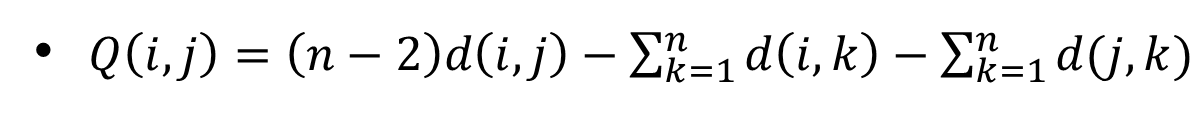

In [22]:
Q = dist.copy()
Q

,0,1,2,3,4,5,6,paired,paired_no_dist
0,0.0000,1.6866,1.7198,1.6606,1.5243,1.6043,1.5905,A,A
1,1.6866,0.0000,1.5232,1.4841,1.4465,1.4389,1.4629,B,B
2,1.7198,1.5232,0.0000,0.7115,0.5958,0.6179,0.5583,C,C
3,1.6606,1.4841,0.7115,0.0000,0.4631,0.5061,0.4710,D,D
4,1.5243,1.4465,0.5958,0.4631,0.0000,0.3484,0.3083,E,E
5,1.6043,1.4389,0.6179,0.5061,0.3484,0.0000,0.2692,F,F
6,1.5905,1.4629,0.5583,0.4710,0.3083,0.2692,0.0000,G,G


In [33]:
Q = dist.copy()
n = len(dist) 

for i in range(n):
  for j in range(i):    
    dist1 = dist.loc[i][~dist.columns.isin(['paired', 'paired_no_dist'])] 
    dist2 = dist.loc[j][~dist.columns.isin(['paired', 'paired_no_dist'])]
    dif = sum(dist1) - sum(dist2)
    Q.loc[i, j] = (n-2) * dist.loc[i][j] - dif
    Q.loc[j, i] = Q.loc[i, j]
Q

,0,1,2,3,4,5,6,paired,paired_no_dist
0,0.0000,9.1769,12.6586,12.7927,12.7212,13.0228,13.0784,A,A
1,9.1769,0.0000,10.9317,11.1663,11.5883,11.4519,11.6965,B,B
2,12.6586,10.9317,0.0000,3.9876,4.0191,4.0312,3.8578,C,C
3,12.7927,11.1663,3.9876,0.0000,2.9255,3.0421,2.9912,D,D
4,12.7212,11.5883,4.0191,2.9255,0.0000,1.6436,1.5677,E,E
5,13.0228,11.4519,4.0312,3.0421,1.6436,0.0000,1.4706,F,F
6,13.0784,11.6965,3.8578,2.9912,1.5677,1.4706,0.0000,G,G


In [25]:
dist

,0,1,2,3,4,5,6,paired,paired_no_dist
0,0.0000,1.6866,1.7198,1.6606,1.5243,1.6043,1.5905,A,A
1,1.6866,0.0000,1.5232,1.4841,1.4465,1.4389,1.4629,B,B
2,1.7198,1.5232,0.0000,0.7115,0.5958,0.6179,0.5583,C,C
3,1.6606,1.4841,0.7115,0.0000,0.4631,0.5061,0.4710,D,D
4,1.5243,1.4465,0.5958,0.4631,0.0000,0.3484,0.3083,E,E
5,1.6043,1.4389,0.6179,0.5061,0.3484,0.0000,0.2692,F,F
6,1.5905,1.4629,0.5583,0.4710,0.3083,0.2692,0.0000,G,G


In [32]:
sum(dist2)

4.6602

In [27]:
dist1 = dist.loc[5][~dist.columns.isin(['paired', 'paired_no_dist'])] 
dist2 = dist.loc[6][~dist.columns.isin(['paired', 'paired_no_dist'])]
dif = sum(dist1) - sum(dist2)

In [ ]:
# Get off diagonal part
def offdiagonal(a):
  offdiag = []
  for i in range(1, a.shape[0]):
    row = []
    for j in range(i):
      row.append(a[i][j])
    offdiag.append(row)
  return offdiag
offdiagonal(distance)

[[1.6866],
 [1.7198, 1.5232],
 [1.6606, 1.4841, 0.7115],
 [1.5243, 1.4465, 0.5958, 0.4631],
 [1.6043, 1.4389, 0.6179, 0.5061, 0.3484],
 [1.5905, 1.4629, 0.5583, 0.471, 0.3083, 0.2692]]